# Tutorial 11e - Optimization of Aspheric Lenses via Reinforcement Learning

In this notebook, we explore how reinforcement learning (RL) can be applied to optimize the design of an aspheric singlet lens. Lens design often involves minimizing the RMS (root mean square) spot size, a performance metric that quantifies the spread of focused light rays. By leveraging RL, we aim to automate this optimization process and discover lens configurations that yield superior optical performance.

This example uses the **Optiland** Python package for ray tracing and optical system analysis, combined with a custom RL environment designed to evaluate and optimize lens parameters. The process will include:

1. Defining a configurable aspheric singlet lens with Optiland.
2. Creating a custom RL environment to model the lens design optimization problem.
3. Training an RL agent to learn how to minimize the RMS spot size.
4. Assessing the agent's performance and validating the results.
5. Conclusions and potential future work.

In [1]:
import numpy as np
from gymnasium import Env, spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

from optiland import analysis, materials, mtf, optic, psf

## Step 1: Defining a Configurable Aspheric Singlet

The first step in this workflow is to define the aspheric singlet lens system. For simplicity, we will only optimize the front surface and make the second surface planar.

To build the configurable lens, we will wrap the `Optic` class from the `optiland.optic` module. The key parameters of the singlet include:

- **Refractive Index (n):** The refractive index at 0.55 µm.
- **Lens Radius:** The radius of curvature of the front lens surface.
- **Lens Thickness:** The distances between lens surfaces.
- **Lens-to-image Thickness**: The distance from the lens second surface to image plane.
- **Aspheric Coefficients:** Terms used to model an even asphere on the lens surfaces. We use three coefficients.
- **F-number:** The ratio of the lens focal length to the entrance pupil diameter.

We'll create a configurable class that encapsulates these parameters. This will serve as the foundation for our RL environment.

Following previous studies [1], we will also enforce a unit focal length. This simplifies optimization, as the agent does not need to learn how to scale the lens. The lens system can later be manually scaled to any desired focal length.


###### [1] Côté G, Lalonde J-F, Thibault S (2019a) Extrapolating from lens design databases using deep learning. Opt Express 27(20):28279–28292

In [2]:
class SingletConfigurable(optic.Optic):
    """A configurable aspheric singlet

    Args:
        n (float): refractive index at 0.55 µm
        radius (float): radius of curvature of the asphere
        t1 (float): thickness of the first surface (lens thickness)
        t2 (float): thickness of the second surface (thickness to image plane)
        coefficients (list): coefficients of the asphere

    """

    def __init__(self, n, radius, t1, t2, coefficients, f_number):
        super().__init__()

        # define the material for the singlet
        mat = materials.IdealMaterial(n=n, k=0)

        # add surfaces
        self.add_surface(index=0, radius=np.inf, thickness=np.inf)
        self.add_surface(
            index=1,
            thickness=t1,
            radius=radius,
            is_stop=True,
            material=mat,
            surface_type="even_asphere",
            conic=0.0,
            coefficients=coefficients,
        )
        self.add_surface(index=2, thickness=t2)
        self.add_surface(index=3)

        # add aperture
        self.set_aperture(aperture_type="imageFNO", value=f_number)

        # add field
        self.set_field_type(field_type="angle")
        self.add_field(y=0.0)

        # add wavelength
        self.add_wavelength(value=0.55, is_primary=True)

        self.scale_to_unity_focal_length()

    def scale_to_unity_focal_length(self):
        """Scale the system to unity focal length"""
        f = self.paraxial.f2()
        self.scale_system(1 / f)

We build and draw a sample lens:

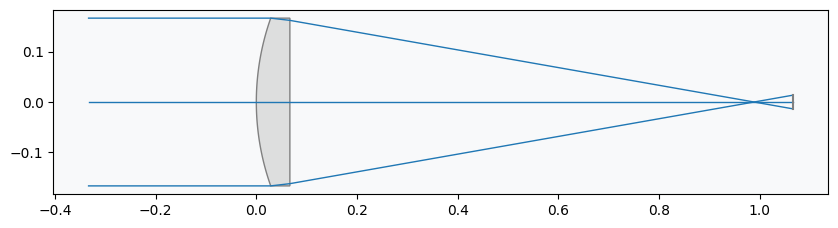

In [3]:
lens = SingletConfigurable(
    n=1.5,
    radius=75,
    t1=10,
    t2=150,
    coefficients=[0, 0, 0],
    f_number=3,
)
lens.draw()

## Step 2: Creating the RL Environment for Lens Optimization

To apply reinforcement learning, we need to define the problem as an RL environment. The environment models the process of optimizing the lens design, with the following key components:

- **System State:** Represents the lens parameters (e.g., refractive index, radius, thicknesses, aspheric coefficients). Used to generate a lens for RMS spot size calculation.
- **Observation Space**: Represents the observables of the system, including all lens parameters, the F-number and the RMS spot size.
- **Action Space:** Defines how the agent can adjust the system state during optimization.
- **Reward Function:** Guides the RL agent by providing feedback on the quality of the current lens configuration. In this case, the reward penalizes increases in RMS spot size and incentivizes quickly achieving a smaller RMS.

We'll implement the environment using the [OpenAI Gym](https://gymnasium.farama.org/) API. The environment will also handle edge cases, such as invalid lens configurations or `NaN` values, to ensure robust training.

Following recommendation from the [Stable Baselines3 documentation](https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html), we will scale the observation and action spaces to the range [-1, 1]. We only unscale the parameters when needed to generate a lens system.

In [4]:
class LensDesignEnv(Env):
    """Custom RL environment for optimizing lens design parameters.

    Args:
        max_steps (int): maximum number of steps per episode

    """

    def __init__(self, max_steps=100):
        self.max_steps = max_steps
        self.current_step = 0
        self.rms_threshold = -0.999999

        # Observation space: (n, radius, t1, t2, coefficients (x3), f/#, rms spot size)
        self.observation_space = spaces.Box(
            low=-1,
            high=1,
            shape=(9,),
            dtype=np.float32,
        )

        # Action space: (n, radius, t1, t2, coefficients (x3))
        self.action_space = spaces.Box(low=-1, high=1, shape=(7,), dtype=np.float32)

        # Lens parameter ranges (unscaled)
        self.low = np.array([1.2, 15, 1, 1, -1e-3, -1e-3, -1e-3])
        self.high = np.array([1.8, 500, 5, 500, 1e-3, 1e-3, 1e-3])

        self.state = None
        self.prev_rms_spot_size = None  # To track changes in RMS between steps
        self.reset()

    def reset(self, seed=None):
        """Resets the environment and initializes a random state."""
        if seed is not None:
            np.random.seed(seed)

        self.current_step = 0
        self.state = np.random.uniform(-1, 1, size=7).astype(np.float32)
        f_number = np.random.uniform(1, 8)
        self.f_number = np.float32((f_number - 1) / 3.5 - 1)  # Scale to [-1, 1]
        rms = self._get_rms_spot_size()
        self.prev_rms_spot_size = rms  # Initialize previous RMS

        return self._get_obs(rms), {}

    def step(self, action):
        """Applies the action, computes the next state, reward, and termination flags."""
        # Update state with action and clip to valid range
        self.state = np.clip(self.state + action, -1, 1)

        # Compute observation and RMS spot size
        rms_spot_size = self._get_rms_spot_size()
        obs = self._get_obs(rms_spot_size)

        # Calculate reward
        reward, done, truncated = self._compute_reward_and_flags(rms_spot_size)

        # Update previous RMS spot size
        self.prev_rms_spot_size = rms_spot_size

        # Increment step counter
        self.current_step += 1
        if self.current_step >= self.max_steps:
            done = True

        return obs, float(reward), done, truncated, {}

    def render(self, mode="human"):
        """Renders the current state (prints to console)."""
        print(f"Current State: {self.state}")

    def _get_obs(self, rms):
        """Constructs the observation vector including the state, f-number, and RMS spot size."""
        if np.isnan(rms):
            rms = np.float32(1)
        return np.concatenate([self.state, [self.f_number, rms]])

    def _unscale_state(self):
        """Converts the scaled state back to the original parameter range."""
        return self.low + 0.5 * (self.state + 1) * (self.high - self.low)

    def _scale_rms(self, rms):
        """Scales the RMS spot size to the range [-1, 1]."""
        rms = np.clip(rms, 0, 1e3)
        return np.float32(2 * rms / 1e3 - 1)

    def _get_rms_spot_size(self):
        """Calculates the RMS spot size based on the current lens configuration."""
        state = self._unscale_state()
        n, radius, t1, t2 = state[:4]
        coefficients = state[4:7]
        f_number = 3.5 * (self.f_number + 1) + 1  # Scale to [1, 8]

        # Initialize lens configuration and compute RMS spot size
        self.lens = SingletConfigurable(
            n=n,
            radius=radius,
            t1=t1,
            t2=t2,
            coefficients=coefficients,
            f_number=f_number,
        )
        spot = analysis.SpotDiagram(self.lens)
        rms = spot.rms_spot_radius()[0][0]

        return self._scale_rms(rms)

    def _compute_reward_and_flags(self, rms_spot_size):
        """Computes the reward, done, and truncated flags based on the RMS spot size."""
        done = False
        truncated = False

        if np.isnan(rms_spot_size):
            reward = -1000  # Heavy penalty for NaN outputs
            done = True
            truncated = True
        else:
            # Reward RMS near -1 (minimum spot size)
            reward = -0.1 * np.log(max([rms_spot_size + 1, 1e-6]))

            # Penalize increases in RMS spot size
            if (
                self.prev_rms_spot_size is not None
                and rms_spot_size > self.prev_rms_spot_size
            ):
                delta = rms_spot_size - self.prev_rms_spot_size
                reward -= 10 * delta

            # Step penalty to encourage faster convergence
            reward -= 2.0

        # Check for early stopping if RMS spot size is below the threshold
        if rms_spot_size < self.rms_threshold:
            reward += 10  # Bonus for achieving the goal
            done = True

        # Final reward adjustment if the episode ends successfully
        if done and not truncated:
            reward -= 1 * np.log(max([rms_spot_size + 1, 1e-6]))

        return reward, done, truncated

## Step 3: Training the RL Agent to Minimize RMS Spot Size

Once the environment is defined, we can train an RL agent to optimize the lens design. The agent interacts with the environment iteratively, adjusting lens parameters and receiving feedback in the form of rewards. We will use Proximal Policy Optimization (PPO) for the RL algorithm and we will train over 100,000 time steps. This takes 5 minutes on the author's machine.

The goal is to train an agent capable of discovering high-performance lens configurations efficiently, while avoiding undesirable solutions (e.g., large RMS spot sizes or invalid designs).

In [5]:
env = LensDesignEnv()
check_env(env)  # check validity of the environment

In [6]:
# Train the RL agent
model = PPO("MlpPolicy", env, verbose=0, device="cpu")
model.learn(total_timesteps=100_000)

## Step 4: Assessing the Trained Agent and Validating Performance

After training, we evaluate the RL agent's ability to optimize lenses. This involves:

1. Generating new optimized aspheric singlets.
2. Compute spot size diagram to confirm minimal RMS spot size.
3. Compute other performance metrics/charts, including ray aberration fans, PSF, Strehl ratio and MTF. This confirms the design is diffraction-limited.

In [7]:
def generate_new_design(env, model):
    """Generates a new lens design using the trained RL agent."""
    is_successful = False
    while not is_successful:
        # Test the agent
        obs, _ = env.reset()
        done = False

        rewards = []
        num_runs = 0
        while not done:
            action, _states = model.predict(obs)
            obs, reward, done, truncated, _ = env.step(action)
            rewards.append(reward)
            num_runs += 1

        is_successful = np.sum(rewards) > -100  # chosen threshold for successful design

    return env.lens, num_runs, np.sum(rewards)

We generate 3 new singlet designs. The last generated lens will be used for further analysis.

Total reward: -39.4, Average reward: -0.7, Number of runs: 54


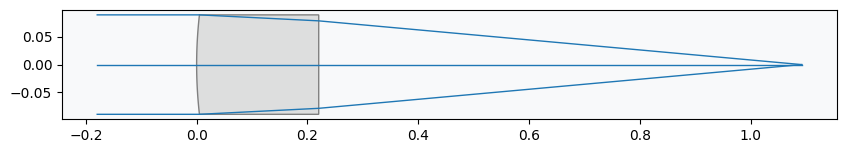

Total reward: -46.7, Average reward: -0.8, Number of runs: 58


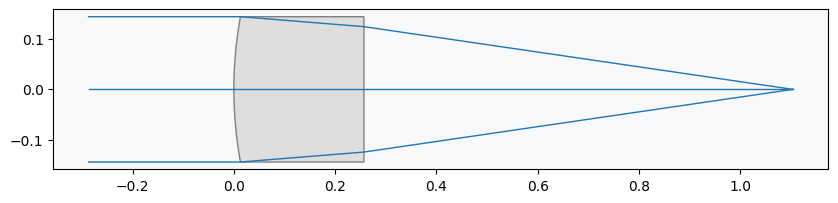

Total reward: 22.1, Average reward: 11.0, Number of runs: 2


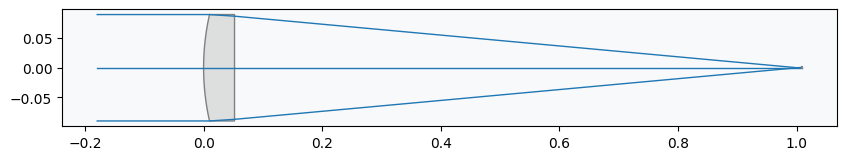

In [14]:
for _ in range(3):
    lens, num_runs, total_reward = generate_new_design(env, model)
    print(
        f"Total reward: {total_reward:.1f}, Average reward: {total_reward / num_runs:.1f}, Number of runs: {num_runs}",
    )
    lens.draw()

It appears that the agent is much better at optimizing lenses with larger F-numbers. Additional training, or reward function tuning, would likely improve the agent's ability further for faster lenses.

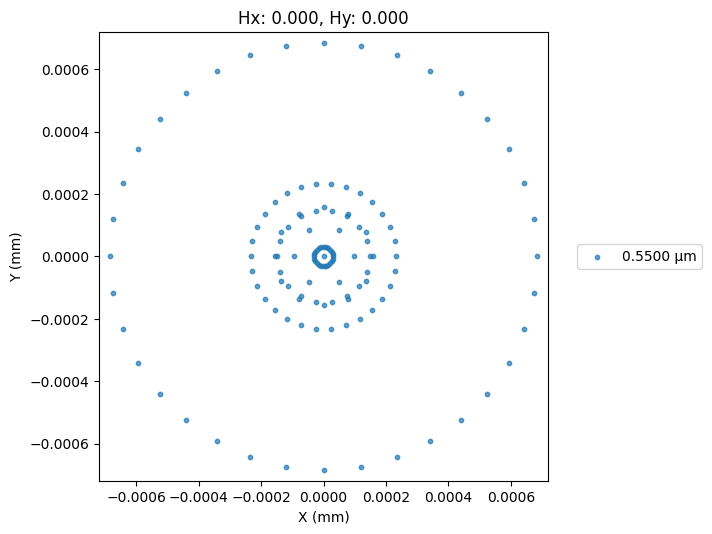

In [15]:
spot = analysis.SpotDiagram(lens)
spot.view(figsize=(18, 6))

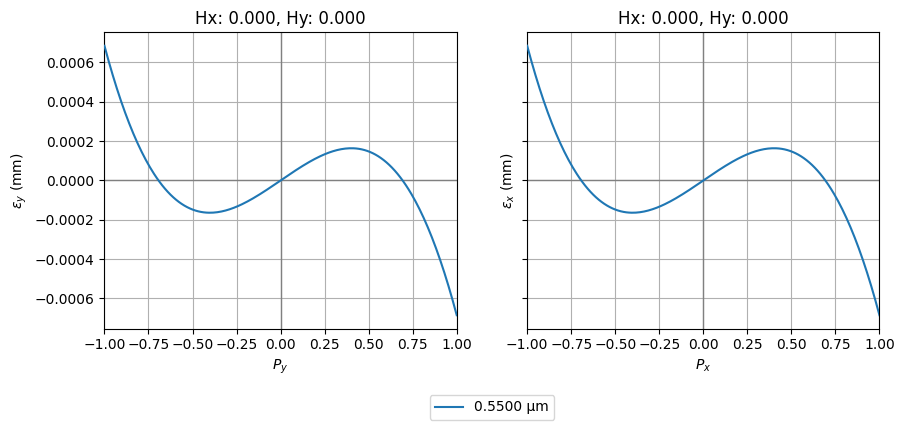

In [16]:
fan = analysis.RayFan(lens)
fan.view()

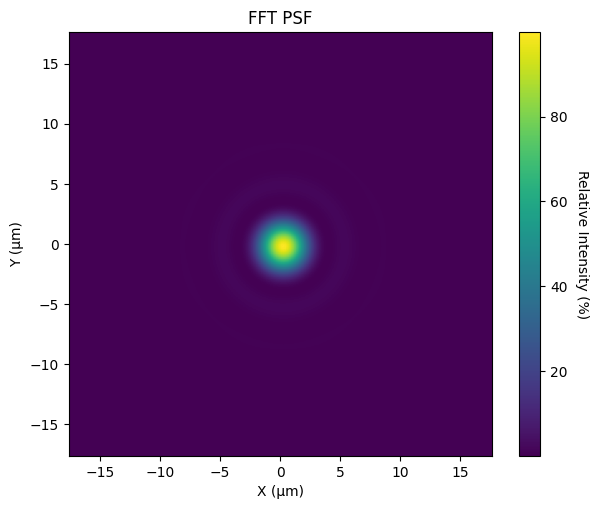

In [17]:
fft_psf = psf.FFTPSF(lens, field=(0, 0), wavelength=0.55)
fft_psf.view(projection="2d", num_points=256)

In [18]:
print(f"Strehl ratio: {fft_psf.strehl_ratio():.3f}")

Strehl ratio: 0.999


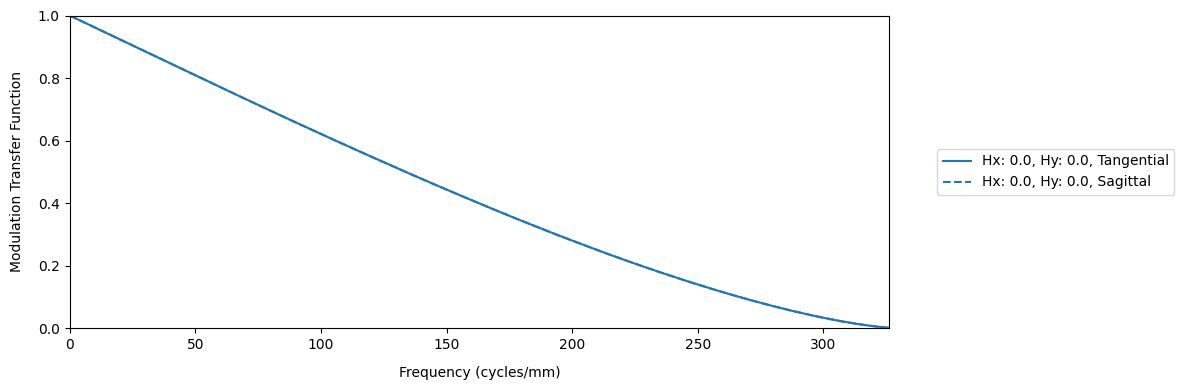

In [19]:
fft_mtf = mtf.FFTMTF(lens)
fft_mtf.view()

## Conclusions and Future Directions

This notebook demonstrated the application of reinforcement learning (RL) for optimizing the design of an aspheric singlet lens. Key takeaways include:

- While traditional optimization techniques may outperform RL for simpler problems like this one, RL offers a versatile framework for exploring high-dimensional, non-linear design spaces, making it promising for more complex optical systems.
- The custom reward function guided the RL agent toward configurations with smaller RMS spot sizes, though further refinement of the reward structure could enhance convergence and solution quality.
- The integration of Optiland into the RL workflow enabled the efficient construction of configurable lens models and the calculation of RMS spot size.

This work provides a foundation for extending RL techniques to more advanced optical systems, such as multi-element lenses or designs with additional performance constraints.

Future efforts could focus on:
- Enhancing the reward function to better balance exploration and exploitation during optimization.
- Incorporating additional optical metrics, such as wavefront error or transmission efficiency.
- Exploring hybrid approaches that combine RL with traditional optimization methods.

For additional examples of how machine learning and deep learning can be applied in optical engineering, see the [LensAI](https://github.com/HarrisonKramer/LensAI) repository.

## References

The methods and concepts demonstrated in this notebook build on ideas from prior research in reinforcement learning, optical engineering, and optimization. Below are key references that informed the development of this example:

1. Côté G, Lalonde J-F, Thibault S (2019a) Extrapolating from lens design databases using deep learning. Opt Express 27(20):28279–28292
2. Tong Yang, Dewen Cheng, and Yongtian Wang, "Designing freeform imaging systems based on reinforcement learning," Opt. Express 28, 30309-30323 (2020)
3. Côté G, Lalonde J-F, Thibault S (2021) Deep learning-enabled framework for automatic lens design starting point generation. Opt Express 29(3):3841–3854